In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

In [18]:
import torchvision
from torchvision import datasets, models, transforms

In [19]:
import os
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import patches, patheffects
import pandas as pd
import json
import cv2
from PIL import ImageDraw, ImageFont
from collections import namedtuple, OrderedDict

In [20]:
from session import *
from LR_Schedule.cos_anneal import CosAnneal
from LR_Schedule.lr_find import lr_find
from callbacks import *
from validation import *
import Datasets.ImageData as ImageData
from Transforms.ImageTransforms import *

In [21]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [22]:
torch.cuda.is_available(), torch.cuda.get_device_name(0), torch.backends.cudnn.enabled

(True, 'GeForce GTX 960M', True)

In [23]:
DATA_PATH = Path('C:/fastai/courses/dl2/data/road_damage_dataset')

In [24]:
MULTICLASS_CSV_PATH = DATA_PATH/'mc.csv'

In [25]:
im_size = 224

In [26]:
train_tfms = TransformList([
        RandomScale(im_size, 1.2),
        RandomCrop(im_size),
        RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_tfms = TransformList([
        Scale(im_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [27]:
batch_size = 4
data = ImageData.from_csv(DATA_PATH, MULTICLASS_CSV_PATH, batch_size, train_tfms, val_tfms)
num_classes = 8

In [28]:
list(data['valid'])[0]

[
 ( 0 , 0 ,.,.) = 
  -1.3254e+00 -1.2948e+00 -1.2733e+00  ...  -9.7065e-01 -1.4398e+00 -1.3642e+00
  -1.3238e+00 -1.3055e+00 -1.3116e+00  ...  -1.2074e+00 -1.7876e+00 -1.2151e+00
  -1.3025e+00 -1.2790e+00 -1.2363e+00  ...  -1.5753e+00 -1.6332e+00 -9.6581e-01
                  ...                   ⋱                   ...                
  -9.5418e-01 -1.3223e+00 -1.2406e+00  ...  -9.7112e-01 -7.6084e-01 -9.0069e-01
  -1.6960e+00 -1.7061e+00 -1.4207e+00  ...  -8.4201e-01 -7.8964e-01 -8.2210e-01
  -1.5861e+00 -1.4738e+00 -1.4143e+00  ...  -1.0280e+00 -9.3652e-01 -8.4823e-01
 
 ( 0 , 1 ,.,.) = 
  -3.0627e-01 -2.7499e-01 -2.5975e-01  ...  -1.8312e-01 -7.6405e-01 -3.7685e-01
  -2.7854e-01 -2.5977e-01 -2.7917e-01  ...  -3.5898e-01 -1.1744e+00 -3.7092e-01
  -2.5637e-01 -2.3271e-01 -1.8906e-01  ...  -7.7681e-01 -1.0716e+00 -3.9660e-01
                  ...                   ⋱                   ...                
  -7.1456e-01 -1.1111e+00 -1.0487e+00  ...  -7.4010e-01 -5.2581e-01 -6.6878e-01


In [ ]:
model_ft = models.resnet18(pretrained=True)
model_ft.avgpool = nn.AdaptiveAvgPool2d(1)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Sequential(
    nn.Dropout(p=.5),
    nn.Linear(num_ftrs, num_classes),
    nn.Sigmoid()
)

In [30]:
model_ft

ResNet(
  (conv1): Conv2d (3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=(1, 1))
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d (64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d (64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d (64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d (64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNo

In [13]:
criterion = nn.BCELoss()
optim_fn = optim.Adam

In [32]:
sess = Session(model_ft, criterion, optim_fn, [*[1e-3] * 9, 1e-2])

In [33]:
sess.freeze() 

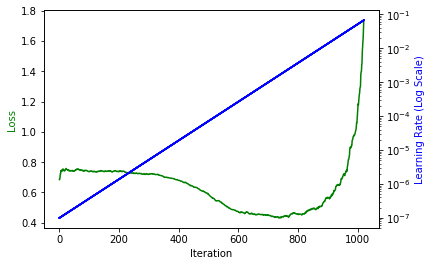

In [16]:
lr_find(sess, data['train'], start_lr=1e-7)

In [34]:
sess.set_lr(1e-3)

In [35]:
accuracy = NHotAccuracy(num_classes)
validator = Validator(data['valid'], accuracy)
lr_scheduler = CosAnneal(len(data['train']), T_mult=2)
schedule = TrainingSchedule(data['train'], [validator, lr_scheduler])

sess.train(schedule, 3)

Training Loss: 0.422679  Validaton Loss: 0.374014 Validation Accuracy: 0.830421


Training Loss: 0.420258  Validaton Loss: 0.369875 Validation Accuracy: 0.831223


Training Loss: 0.411655  Validaton Loss: 0.359913 Validation Accuracy: 0.837553


In [36]:
for detail in accuracy.details:
    print(detail)

{'correct_pos': 16, 'correct_neg': 1014, 'false_pos': 13, 'false_neg': 359}
{'correct_pos': 153, 'correct_neg': 800, 'false_pos': 84, 'false_neg': 365}
{'correct_pos': 0, 'correct_neg': 1309, 'false_pos': 0, 'false_neg': 93}
{'correct_pos': 0, 'correct_neg': 1328, 'false_pos': 0, 'false_neg': 74}
{'correct_pos': 132, 'correct_neg': 994, 'false_pos': 60, 'false_neg': 216}
{'correct_pos': 0, 'correct_neg': 1358, 'false_pos': 0, 'false_neg': 44}
{'correct_pos': 23, 'correct_neg': 1260, 'false_pos': 1, 'false_neg': 118}
{'correct_pos': 219, 'correct_neg': 788, 'false_pos': 146, 'false_neg': 249}


In [37]:
sess.save('TrainLayer1')

In [38]:
sess.load('TrainLayer1')

In [34]:
sess.unfreeze()

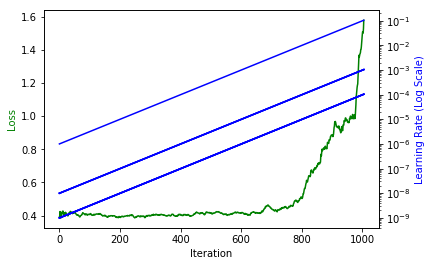

In [39]:
lr_find(sess, data['train'], 
        start_lr=[*[1e-6 / 1000] * 5, *[1e-6 / 100] * 4, 1e-6], 
        end_lr=[*[10 / 1000] * 5, *[10 / 100] * 4, 10])

In [40]:
sess.set_lr([*[1e-4 / 1000] * 5, *[1e-4 / 100] * 4, 1e-4])

In [ ]:
accuracy = NHotAccuracy(num_classes)
validator = Validator(data['valid'], accuracy)
lr_scheduler = CosAnneal(len(data['train']), T_mult=2)
schedule = TrainingSchedule(data['train'], [validator, lr_scheduler])

sess.train(schedule, 7)

Training Loss: 0.398359  Validaton Loss: 0.382273 Validation Accuracy: 0.831580


Training Loss: 0.396856  Validaton Loss: 0.399590 Validation Accuracy: 0.833898


In [ ]:
for detail in accuracy.details:
    print(detail)

In [ ]:
lr_scheduler.plot()

In [ ]:
sess.save('FullTrain')

In [ ]:
sess.load('FullTrain')

In [ ]:
sess.train(schedule, 8)

In [ ]:
sess.save('FullTrain2')

In [ ]:
sess.load('FullTrain2')